In [4]:
import argparse
import json
from pathlib import Path

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from scripts.lib import get_standards_characteristics, load_target_minerals, get_formula, load_images, load_standards_df
from scripts.main import get_variable_percent, simulate_mineral
%alias_magic t timeit

Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


In [5]:
standards_dir = Path('challenge_data/dataset_1_opaques/standards/')
bits = 32
target_minerals_file = Path('challenge_data/dataset_1_opaques/target_minerals.yaml')
meteorite_dir = Path('challenge_data/dataset_1_opaques/obj1/')
meteorite_mask = Path('challenge_data/dataset_1_opaques/obj1/obj1_mask3.tif')
glass_mask = Path('challenge_data/dataset_1_opaques/obj1/glass_mask.tif')

In [6]:
characteristics = get_standards_characteristics(standards_dir, bits)
elements = list(characteristics.keys())
characteristics

Loading standards...
Successfully loaded 10 standards with 8 masks

Loaded 29209 rows
Mineral counts:
{
    "NiS": 4644,
    "FeS": 4115,
    "SCOlv": 4043,
    "Fe3O4": 3969,
    "Fe": 3819,
    "rutile": 3607,
    "CaTiO3": 3470,
    "Ni": 1542
}


{'Ca': {'element': 'Ca',
  'coef': 462.18178605580886,
  'intercept': 0.0,
  'std': 11.257305019123992,
  'noise': 0.7839330547099613},
 'Fe': {'element': 'Fe',
  'coef': 311.200762671983,
  'intercept': 0.0,
  'std': 12.186647205139565,
  'noise': 1.1155958908410162},
 'Mg': {'element': 'Mg',
  'coef': 840.6351519819596,
  'intercept': 0.0,
  'std': 13.785308695058687,
  'noise': 0.4296300849187807},
 'Ni': {'element': 'Ni',
  'coef': 302.78487023791786,
  'intercept': 0.0,
  'std': 14.881467710431,
  'noise': 1.329300610782935},
 'S': {'element': 'S',
  'coef': 210.33838378993957,
  'intercept': 0.0,
  'std': 8.65963719514509,
  'noise': 0.16686134572121533},
 'Si': {'element': 'Si',
  'coef': 1016.951679300757,
  'intercept': 0.0,
  'std': 12.817817389598144,
  'noise': 1.234352733486251},
 'Ti': {'element': 'Ti',
  'coef': 1286.594667115852,
  'intercept': 0.0,
  'std': 21.114220834883863,
  'noise': 2.2062585039459766},
 'P': {'element': 'P',
  'coef': 200.0,
  'intercept': 0.0,
 

In [32]:
n = 1000
target_minerals = load_target_minerals(target_minerals_file)
mineral_dfs = []
for mineral, formula in target_minerals.items():
    df = simulate_mineral(mineral, formula, characteristics, n)
    mineral_dfs.append(df[elements + ['mineral']])
    
df = pd.concat(mineral_dfs)

# Include unknown
unknown = pd.DataFrame(np.clip(
    np.hstack([
        np.clip(np.random.uniform(-2*m, m, (n*10, 1)), 0, None) + np.random.normal(scale=10, size=(n*10, 1))
        for m in df[elements].max(axis=0)
    ]), 0, None), columns=elements
)
unknown['mineral'] = 'Unknown'
df = pd.concat([df, unknown])

X = df[elements].values
Y = df['mineral']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.1)

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, Sum, Product)

#model = GaussianNB()
#model = KNeighborsClassifier(10, weights='distance')
#model = RandomForestClassifier(max_depth=15)
#model = GaussianProcessClassifier(copy_X_train=False, n_jobs=-1, multi_class='one_vs_one', max_iter_predict=1)

#model.fit(X_train, Y_train)
#print("Training Accuracy:", (model.predict(X_train) == Y_train).mean())
#print("Testing Accuracy:", (model.predict(X_test) == Y_test).mean())

#model = KNeighborsClassifier(10, weights='distance', p=1)
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=1000, n_iter_no_change=10, batch_size=32)
model.fit(X_train, Y_train)
print("Training Accuracy:", (model.predict(X_train) == Y_train).mean())
print("Testing Accuracy:", (model.predict(X_test) == Y_test).mean())

Training Accuracy: 0.957037037037037
Testing Accuracy: 0.945


In [33]:
model.set_params(batch_size=64, n_iter_no_change=5)
model.fit(X_train, Y_train)
print("Training Accuracy:", (model.predict(X_train) == Y_train).mean())
print("Testing Accuracy:", (model.predict(X_test) == Y_test).mean())

Training Accuracy: 0.9556481481481481
Testing Accuracy: 0.9475


In [34]:
model.set_params(batch_size=128, n_iter_no_change=5)
model.fit(X_train, Y_train)
print("Training Accuracy:", (model.predict(X_train) == Y_train).mean())
print("Testing Accuracy:", (model.predict(X_test) == Y_test).mean())

Training Accuracy: 0.917037037037037
Testing Accuracy: 0.9141666666666667


In [35]:
model.set_params(batch_size=256, n_iter_no_change=5)
model.fit(X_train, Y_train)
print("Training Accuracy:", (model.predict(X_train) == Y_train).mean())
print("Testing Accuracy:", (model.predict(X_test) == Y_test).mean())

Training Accuracy: 0.9289814814814815
Testing Accuracy: 0.92875


In [36]:
model.set_params(batch_size=512, n_iter_no_change=5)
model.fit(X_train, Y_train)
print("Training Accuracy:", (model.predict(X_train) == Y_train).mean())
print("Testing Accuracy:", (model.predict(X_test) == Y_test).mean())

Training Accuracy: 0.9174074074074074
Testing Accuracy: 0.91875


In [37]:
model.set_params(batch_size=32, n_iter_no_change=5)
model.fit(X_train, Y_train)
print("Training Accuracy:", (model.predict(X_train) == Y_train).mean())
print("Testing Accuracy:", (model.predict(X_test) == Y_test).mean())

Training Accuracy: 0.9551851851851851
Testing Accuracy: 0.9475


In [147]:
meteorite_df, meteorite_shape = load_images(meteorite_dir, bits, meteorite_mask)
glass_df, glass_shape = load_images(meteorite_dir, bits, glass_mask)



11717


In [151]:
for neighbors in range(5, 50, 5):
    for p in [1, 2]:
        for weight in ['uniform', 'distance']:
            print(neighbors, p, weight)
            print('='*40)
            
            model = KNeighborsClassifier(neighbors, weights=weight, p=p)
            model.fit(X_train, Y_train)
            print("Training Accuracy:", (model.predict(X_train) == Y_train).mean())
            print("Testing Accuracy:", (model.predict(X_test) == Y_test).mean())

            x1 = meteorite_df[elements].values
            meteorite_df['mineral'] = model.predict(x1)

            print('Unknown in meteorite:', len(meteorite_df[(meteorite_df['mask'] > 0) & (meteorite_df['mineral'] == 'Unknown')]))

            x2 = glass_df[elements].values
            glass_df['mineral'] = model.predict(x2)

            print('Unknown in glass:', len(glass_df[(glass_df['mask'] > 0) & (glass_df['mineral'] == 'Unknown')]))
            print('Albite in glass:', len(glass_df[(glass_df['mask'] > 0) & (glass_df['mineral'] == 'Albite')]))

            print()

5 1 uniform
Training Accuracy: 0.9460648148148149
Testing Accuracy: 0.9308333333333333
Unknown in meteorite: 12100
Unknown in glass: 9397
Albite in glass: 1601

5 1 distance
Training Accuracy: 1.0
Testing Accuracy: 0.9325
Unknown in meteorite: 12599
Unknown in glass: 9522
Albite in glass: 1600

5 2 uniform
Training Accuracy: 0.9502777777777778
Testing Accuracy: 0.9375
Unknown in meteorite: 13179
Unknown in glass: 11246
Albite in glass: 283

5 2 distance
Training Accuracy: 1.0
Testing Accuracy: 0.9383333333333334
Unknown in meteorite: 13661
Unknown in glass: 11317
Albite in glass: 283

10 1 uniform
Training Accuracy: 0.9354629629629629
Testing Accuracy: 0.92875
Unknown in meteorite: 10830
Unknown in glass: 7982
Albite in glass: 2559

10 1 distance
Training Accuracy: 1.0
Testing Accuracy: 0.9341666666666667
Unknown in meteorite: 11717
Unknown in glass: 8975
Albite in glass: 1961

10 2 uniform
Training Accuracy: 0.9395833333333333
Testing Accuracy: 0.9325
Unknown in meteorite: 11664
Unkno

In [149]:
x2 = glass_df[elements].values
glass_df['mineral'] = model.predict(x2)

print('Unknown in glass:', len(glass_df[(glass_df['mask'] > 0) & (glass_df['mineral'] == 'Unknown')]))
print('Albite in glass:', len(glass_df[(glass_df['mask'] > 0) & (glass_df['mineral'] == 'Albite')]))

Unknown in glass: 8975
Albite in glass: 1961


In [3]:
#%%t -n1 -r2

X = df[elements].values
Y = df['mineral']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.1)

'''model = GaussianProcessClassifier(
    #1.0* RBF(1.0), 
    #ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed"),
    ConstantKernel(1.0, constant_value_bounds=(.001, 1e2)) * (DotProduct(sigma_0=1.0, sigma_0_bounds=(.001, 1e2)) ** 2),
    #Sum(
    #    ConstantKernel(1.0, constant_value_bounds="fixed") * (DotProduct(sigma_0=1.0, sigma_0_bounds="fixed") ** 2),
    #    ConstantKernel(1.0, constant_value_bounds="fixed") * (DotProduct(sigma_0=1.0, sigma_0_bounds="fixed") ** 2)
    #),
    copy_X_train=False, n_jobs=1, multi_class='one_vs_rest', max_iter_predict=100, n_restarts_optimizer=2
)'''
#model = SVC(C=.1, kernel='linear', decision_function_shape='ovr')
#model = SVC(C=.1, kernel='poly', degree=2, decision_function_shape='ovr')
#model = GaussianNB()
#model = RandomForestClassifier(50, max_depth=5)
model = KNeighborsClassifier(10, weights='distance')
model.fit(X_train, Y_train)
print("Training Accuracy:", (model.predict(X_train) == Y_train).mean())

#X_, X_test, Y_, Y_test = train_test_split(X_test, Y_test, test_size=.01)
print("Testing Accuracy:", (model.predict(X_test) == Y_test).mean())

NameError: name 'df' is not defined

In [95]:
q = model.kernel_.kernels[0]
q.theta

array([], dtype=float64)

In [91]:
model.kernel_.get_params()

{'kernels': [1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0=1) ** 2,
  1**2 * DotProduct(sigma_0

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(X_test, Y_test, test_size=.05)
print("Testing Accuracy:", (model.predict(X_test) == Y_test).mean())

Testing Accuracy: 0.22127946127946127


In [21]:
X_train.shape

(7500, 8)

In [17]:
meteorite_df, meteorite_shape = load_images(meteorite_dir, bits, meteorite_mask)
x = meteorite_df[elements].values
meteorite_df['mineral'] = model.predict(x)

In [6]:
(meteorite_df['mask'] > 0).sum()

41923

In [8]:
meteorite_df[meteorite_df['mask'] > 0]

,order,Al,Ca,Cr,Fe,Mg,Ni,P,S,Si,Ti,mask,mineral
75855,75855,0,3,19,296,0,9,4,0,3,3,1,Kamacite
75856,75856,0,2,11,306,0,5,2,0,0,5,1,Kamacite
75857,75857,0,0,13,273,0,15,4,0,3,3,1,Kamacite
75858,75858,2,0,17,289,0,4,0,0,2,5,1,Kamacite
75859,75859,0,0,11,326,1,9,2,0,2,0,1,Kamacite
75860,75860,0,0,13,301,0,10,3,0,1,4,1,Kamacite
75861,75861,3,0,10,287,0,8,0,0,3,2,1,Kamacite
75862,75862,2,0,11,233,0,8,2,2,2,4,1,Magnetite
76365,76365,0,0,17,290,0,10,2,0,0,2,1,Kamacite
76366,76366,0,0,11,292,0,5,2,0,3,6,1,Kamacite


In [144]:
meteorite_df, meteorite_shape = load_images(meteorite_dir, bits, glass_mask)
x = meteorite_df[elements].values
meteorite_df['mineral'] = model.predict(x)

In [140]:
norm = plt.Normalize(0, 1)

13 ['Albite', 'Anorthite', 'Diopside', 'Kamacite', 'MSS', 'Magnetite', 'Olivine', 'Pentlandite', 'Pyroxene', 'Schreibersite', 'Taenite', 'Troilite', 'Unknown']
9 ['Albite', 'Anorthite', 'Diopside', 'Kamacite', 'Magnetite', 'Olivine', 'Pyroxene', 'Taenite', 'Unknown']


/home/docmario/miniconda3/envs/haiku/lib/python3.6/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


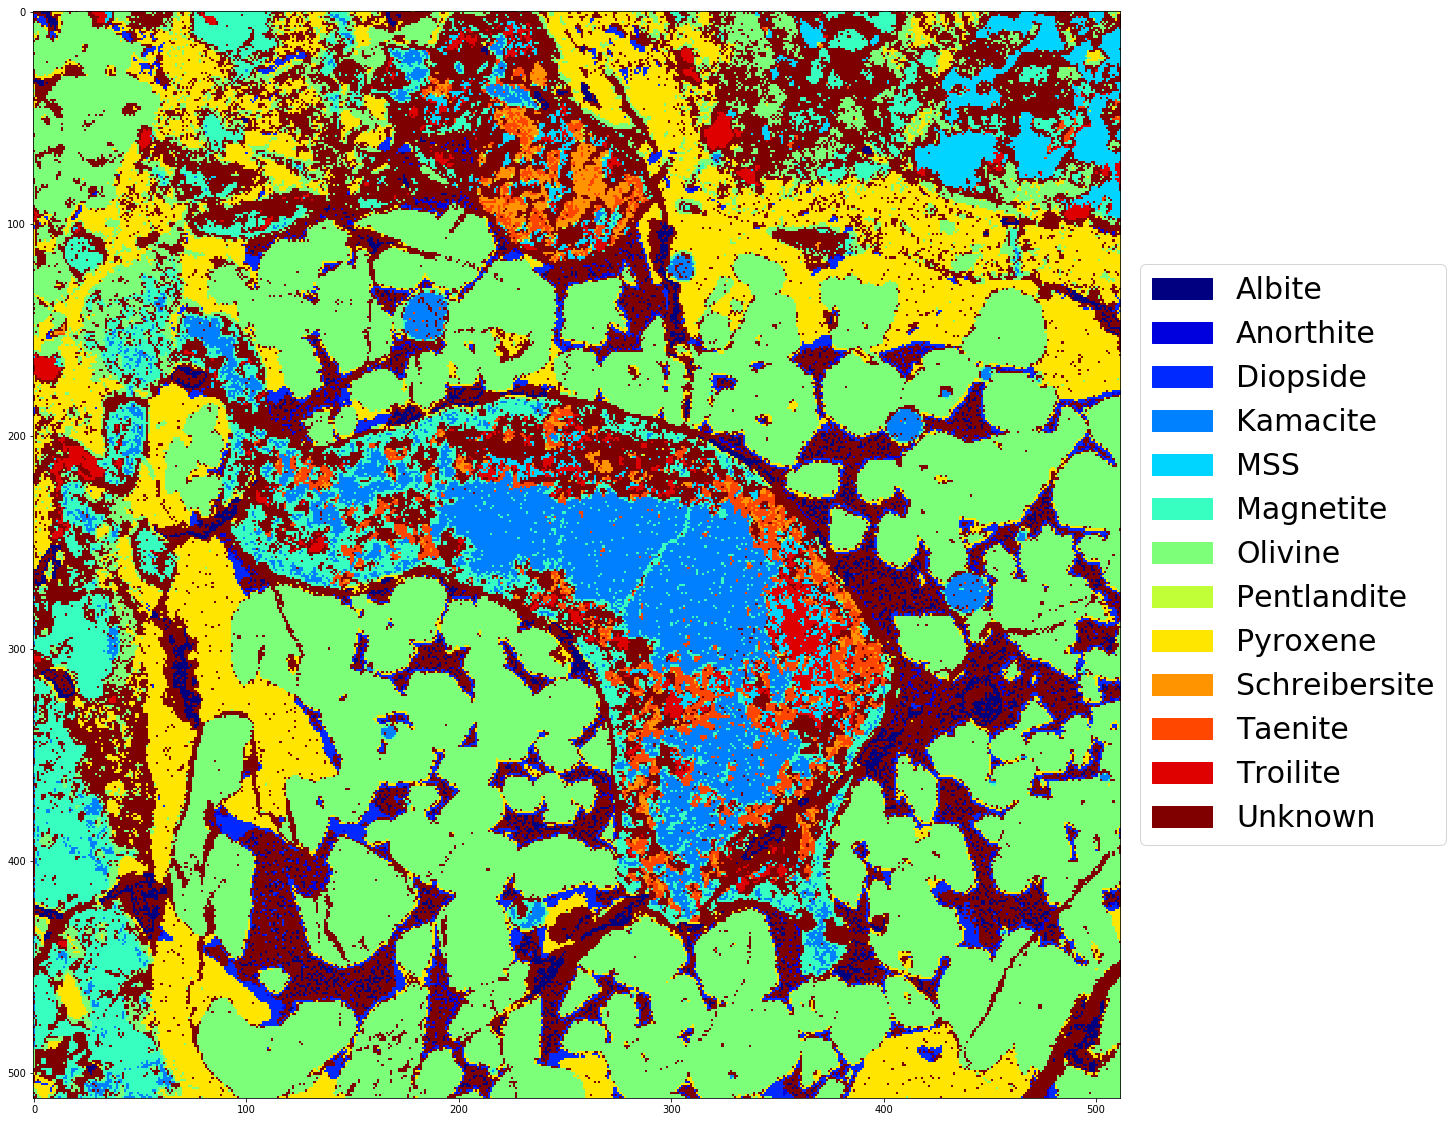

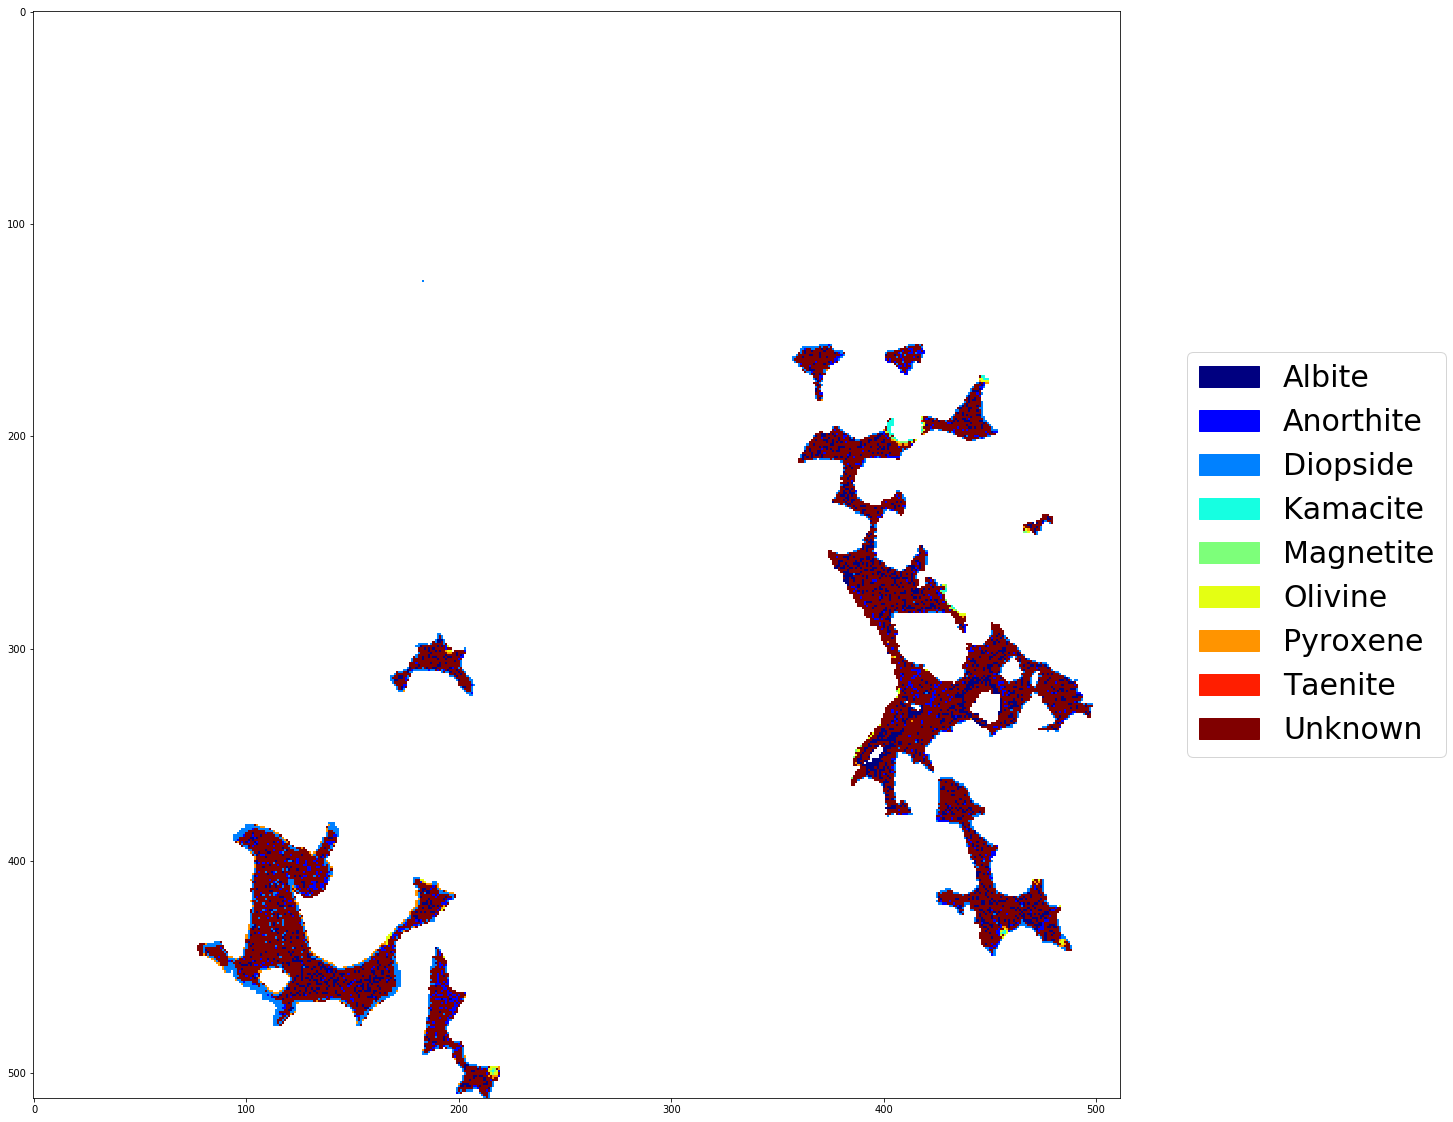

In [145]:
for mask in [False, True]:
    if mask:
        minerals = sorted(meteorite_df[meteorite_df['mask'] > 0]['mineral'].unique())
    else:
        minerals = sorted(meteorite_df['mineral'].unique())
    print(len(minerals), minerals)
    results = meteorite_df.merge(
        pd.Series(
            minerals, name='mineral'
        ).reset_index().rename(columns={'index': 'mineral_index'}),
        on='mineral', how='left'
    ).sort_values('order')
    
    figure, ax = plt.subplots(figsize=(20,20))
    norm = plt.Normalize(0, len(minerals)-1)
    cmap = plt.cm.get_cmap('jet')
    rgb = cmap(norm(results['mineral_index'].values.reshape(meteorite_shape)))
    if mask:
        #rgb[...,1] = 1
        #rgb[..., -1] = ((results['mineral'] == 'Diopside') & (results['mask'])).values.reshape(meteorite_shape)
        rgb[..., -1] = results['mask'].values.reshape(meteorite_shape)
    im = ax.imshow(rgb)

    colors = [cmap(norm(i)) for i in range(len(minerals))]
    patches = [
        mpatches.Patch(
            color=colors[i], label=minerals[i]
        ) for i in range(len(minerals))
    ]
    ax.legend(
        handles=patches, bbox_to_anchor=(1.3, .5, 0, 0),
        loc=5, borderaxespad=0., fontsize=30
    )


In [130]:
rgb.shape

(512, 512, 4)

In [117]:
results[results['mask'] > 0].groupby('mineral_index').count()

,order,Al,Ca,Cr,Fe,Mg,Ni,P,S,Si,Ti,mask,mineral
mineral_index,,,,,,,,,,,,,
0.0,1963,1963,1963,1963,1963,1963,1963,1963,1963,1963,1963,1963,1963
1.0,817,817,817,817,817,817,817,817,817,817,817,817,817
2.0,1469,1469,1469,1469,1469,1469,1469,1469,1469,1469,1469,1469,1469
3.0,368,368,368,368,368,368,368,368,368,368,368,368,368
4.0,70,70,70,70,70,70,70,70,70,70,70,70,70
5.0,104,104,104,104,104,104,104,104,104,104,104,104,104
6.0,210,210,210,210,210,210,210,210,210,210,210,210,210
7.0,11,11,11,11,11,11,11,11,11,11,11,11,11
8.0,9113,9113,9113,9113,9113,9113,9113,9113,9113,9113,9113,9113,9113


In [112]:
meteorite_df[meteorite_df['mask'] > 0].groupby('mineral').count()

,order,Al,Ca,Cr,Fe,Mg,Ni,P,S,Si,Ti,mask
mineral,,,,,,,,,,,,
Albite,1963,1963,1963,1963,1963,1963,1963,1963,1963,1963,1963,1963
Anorthite,817,817,817,817,817,817,817,817,817,817,817,817
Diopside,1469,1469,1469,1469,1469,1469,1469,1469,1469,1469,1469,1469
Kamacite,368,368,368,368,368,368,368,368,368,368,368,368
Magnetite,70,70,70,70,70,70,70,70,70,70,70,70
Olivine,104,104,104,104,104,104,104,104,104,104,104,104
Pyroxene,210,210,210,210,210,210,210,210,210,210,210,210
Taenite,11,11,11,11,11,11,11,11,11,11,11,11
Unknown,9113,9113,9113,9113,9113,9113,9113,9113,9113,9113,9113,9113


In [123]:
cmap(2), cmap(8)

((0.0, 0.5, 1.0, 1.0), (0.5, 0.0, 0.0, 1.0))

In [138]:
rgb.reshape(-1,4)[results['mineral'] == 'Diopside']

array([[0.5, 0. , 0. , 0. ],
       [0.5, 0. , 0. , 0. ],
       [0.5, 0. , 0. , 0. ],
       ...,
       [0.5, 0. , 0. , 0. ],
       [0.5, 0. , 0. , 0. ],
       [0.5, 0. , 0. , 0. ]])

In [108]:
meteorite_df['mask'].max()

1

In [10]:
df['Fe'].values.reshape(shape).shape

(512, 512)

In [11]:
df['mask'].values.reshape(shape).shape

(512, 512)